# 实验分析
包括：
- 训练数据统计
- 基于tSNE的字形视觉特征可视化

## 训练数据的统计情况

In [28]:

from megec.util import BetterFile

lines = BetterFile('./data/train_realise.txt').read_lines()
sources = []
for line in lines:
    source = line.strip().split("\t")[0]
    if '-' in source:
        sources.append(source[:source.find('-')])
    else:
        sources.append(source)

数据分布情况

In [54]:
sighan13, sighan14, sighan15, wang27k = [], [], [], []

def error_chars(s, t):
    return sum([a!=b for a, b in zip(s, t)])

for line in lines:
    source, src, tgt = line.strip().split("\t")
    c = error_chars(src, tgt)
    if source[:8] == 'sighan13':
        sighan13.append({'source': source, 'src': src, 'tgt': tgt, 'err': c})
    elif source[:8] == 'sighan14':
        sighan14.append({'source': source, 'src': src, 'tgt': tgt, 'err': c})
    elif source[:8] == 'sighan15':
        sighan15.append({'source': source, 'src': src, 'tgt': tgt, 'err': c})
    else:
        wang27k.append({'source': source, 'src': src, 'tgt': tgt, 'err': c})


In [63]:
def display(name, d):
    total_chars = sum([len(a['src']) for a in d])
    num_errors = sum([a['err'] for a in d])
    pairs = [a['src'] + a['tgt'] for a in d]
    num_duplicates = len(pairs) - len(set(pairs))
    print(name)
    print(f'\t\t句子数：{len(d)}')
    print(f'\t\t总长度：{total_chars}')
    print(f'\t\t平均长度{total_chars/len(d)}')
    print(f'\t\t错误数：{num_errors}')
    print(f'\t\t重复句子数：{num_duplicates}')
    print('-------------------')

display('sighan13', sighan13)
display('sighan14', sighan14)
display('sighan15', sighan15)
display('wang27k', wang27k)

print(f'总句子数量：{len(lines)}')
total_chars = sum([len(a['src']) for a in sighan13])
total_chars += sum([len(a['src']) for a in sighan14])
total_chars += sum([len(a['src']) for a in sighan15])
total_chars += sum([len(a['src']) for a in wang27k])
print(f'平均句子长度：{total_chars/len(lines)}')


sighan13
		句子数：1397
		总长度：58385
		平均长度41.79312813171081
		错误数：685
		重复句子数：709
-------------------
sighan14
		句子数：6850
		总长度：336582
		平均长度49.136058394160585
		错误数：10156
		重复句子数：3425
-------------------
sighan15
		句子数：4673
		总长度：146011
		平均长度31.245666595334903
		错误数：6045
		重复句子数：2336
-------------------
wang27k
		句子数：271281
		总长度：11540761
		平均长度42.54172242066345
		错误数：381863
		重复句子数：3573
-------------------
总句子数量：284201
平均句子长度：42.511247321438


In [37]:
import pickle

with open('./data/realise/trainall.times2.pkl', 'rb') as f:  
    data = pickle.load(f)  


In [62]:
len(data)

284201

In [70]:
import pickle

with open('./data/realise/test.sighan15.pkl', 'rb') as f:  
    test_data = []
    for a in pickle.load(f):
        src, tgt = a['src'], a['tgt']
        c = error_chars(src, tgt)
        test_data.append({'src': src, 'tgt': tgt, 'err': c})

In [71]:
display('test data', test_data)

test data
		句子数：1100
		总长度：33665
		平均长度30.604545454545455
		错误数：703
		重复句子数：0
-------------------


## 基于ViT得到的汉字Embedding结果的可视化

利用ViT，把汉字图像输入到ViT预训练后的网络，得到嵌入表示结果，将该结果作为汉字的字形特征。用tSNE可视化的结果如下：

In [5]:
import matplotlib.pyplot as plt  
from sklearn.manifold import TSNE  
import numpy as np  
from megec.vocab import glyph_vocab

# 加载字形文件
glyph_vocab.load()
vocab = glyph_vocab.vocab
vocab = np.array(vocab)

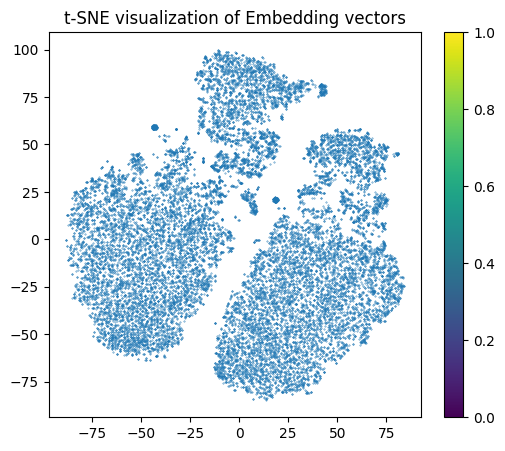

In [8]:
a = vocab
# 使用t-SNE进行降维  
tsne = TSNE(n_components=2, random_state=0)  
a_2d = tsne.fit_transform(a)  
  
# 绘制结果  
plt.figure(figsize=(6, 5))  
plt.scatter(a_2d[:, 0], a_2d[:, 1], s=0.1)  # s参数控制点的大小  
plt.colorbar()  # 添加颜色条  
plt.title('t-SNE visualization of Embedding vectors')  
plt.show()

挑选一部分形近字，进行可视化，看其是否能将相似的字聚到一起

In [14]:
from megec.conf import bert_tokenizer
word_labels = list('己已巳木本未来末治冶尧饶绕浇挠烧遥摇瑶谣甬通痛桶诵捅俑涌迪笛油邮袖庙宙口日曰目瑰愧槐魏魄魂刚钢岗纲刚他她驰弛')
word_ids = [bert_tokenizer.vocab[w] for w in word_labels]
word_vectors = [vocab[id] for id in word_ids]


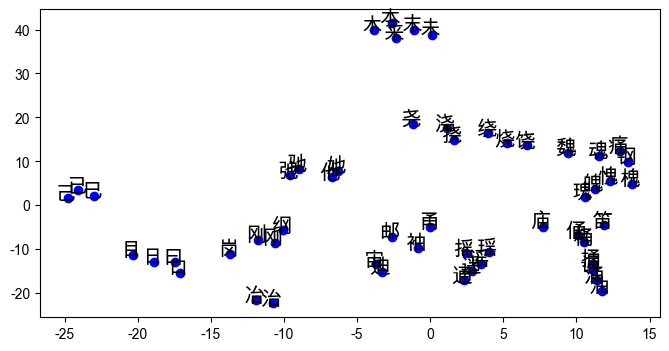

In [27]:
plt.rcParams['font.family']='Arial Unicode MS' # 设置中文字体
plt.rcParams['font.sans-serif']=['Arial Unicode MS'] # 设置中文字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题
plt.figure(figsize=(8, 4))


vectors = np.array(word_vectors)
 # run t-SNE on the word vectors
tsne = TSNE(n_components=2, perplexity=5, random_state=11, learning_rate=5, n_iter=1200)
Y = tsne.fit_transform(vectors)
 # plot the word vectors
#colors = ['red', 'blue']
plt.scatter(Y[:, 0], Y[:, 1], c='b')
for i in range(len(vectors)):
    plt.annotate(word_labels[i], xy=(Y[i, 0], Y[i, 1]), xytext=(6, -4), textcoords='offset points', ha='right', va='bottom',fontsize=15)
plt.savefig('shape.png')
plt.show()